In [608]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd
plt.style.use(['ggplot','seaborn-talk'])
# plt.style.use(['fivethirtyeight','seaborn-talk'])

# We will use the odeint routine
from scipy.integrate import odeint
# With a wrapper to facilitate 2d arrays
from odeintw import odeintw

### FUNCTIONS

In [609]:
# Probabilities for heating and cooling based on Ti
def tProb(x,mu,lag,slope=.25):
    y = 1/(1+np.e**-(slope*(x-mu-lag)))
    return y

# Efficiency curves - based on technology & Ta
def hEfficiency(Ta):
    eff = -.05*np.e**(-.2*Ta)+1
    return eff

def fEfficiency(Ta):
    eff = 0.9 + 1/1000 * Ta
    return eff

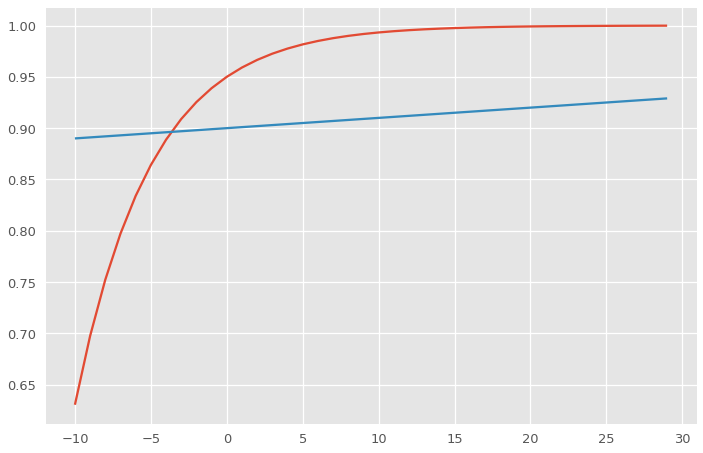

In [610]:
hE = []
fE = []
for Ta in range(-10,30):
    hE.append(hEfficiency(Ta))
    fE.append(fEfficiency(Ta))

plt.plot(range(-10,30),hE)
plt.plot(range(-10,30),fE);

## THERMAL MODEL

In [646]:
# Master Equations with Temperature
@jit(nopython=True)
def J3(x, alpha_p, alpha_m, phi_p, phi_m, gamma_p, gamma_m, beta_p, beta_m, L, F, H, omega, Ph,Pc,h_eff,f_eff):
    """
    Time derivative of the occupation numbers.

        * x is the state distribution (array like)
        * alpha - transition b/t p[00] and p[01]
        * phi - transition b/t p[00] and p[01]
        * gamma - transition b/t p[00] and p[01]
        * beta - transition b/t p[00] and p[01]
        * L - loss from no heat
        * F - heating for fossil
        * H - heating for heat pump
        * omega - heating for both
        * Tset - desired setpoint inside
        * Ta - ambient temperature (outside)
    """
    K = x.shape[0]

    dx = 0*x
    for Ti, h, f in np.ndindex(x.shape):
        
        Cadj = Pc[Ti] # setpoint range for cooling
        Hadj = Ph[Ti] # setpoint range for heating

        #Teff = # heating becomes less efficient at colder temperatures
        
        if h == 0 and f == 0: # all off p[0,0]
            dx[Ti,h,f] -= x[Ti,h,f]*alpha_p * Hadj     # f on
            dx[Ti,h,f] += x[Ti,h,f+1]*alpha_m * Cadj   # f off
            dx[Ti,h,f] -= x[Ti,h,f]*phi_p * Hadj       # h on
            dx[Ti,h,f] += x[Ti,h+1,f]*phi_m * Cadj     # h off
            
            if Ti < x.shape[0]-1:
                dx[Ti,h,f] += x[Ti+1,h,f]*L # cooling off from above
            if Ti > 0:
                dx[Ti,h,f] -= x[Ti,h,f]*L # cooling off to Ti-1
        
        if h == 1 and f == 0: # hp on p[1,0]
            dx[Ti,h,f] -= x[Ti,h,f]*gamma_p * Hadj
            dx[Ti,h,f] += x[Ti,h,f+1]*gamma_m * Cadj
            dx[Ti,h,f] -= x[Ti,h,f]*phi_m * Cadj
            dx[Ti,h,f] += x[Ti,h-1,f]*phi_p * Hadj
            
            if Ti < x.shape[0]-1:
                dx[Ti,h,f] -= x[Ti,h,f]*H*h_eff # leaving to hotter state
            if Ti > 0: 
                dx[Ti,h,f] += x[Ti-1,h,f]*H*h_eff # entering from cooler state
             
        if h == 0 and f == 1: # f on p[0,1]
            dx[Ti,h,f] -= x[Ti,h,f]*beta_p * Hadj
            dx[Ti,h,f] += x[Ti,h+1,f]*beta_m * Cadj
            dx[Ti,h,f] -= x[Ti,h,f]*alpha_m * Cadj
            dx[Ti,h,f] += x[Ti,h,f-1]*alpha_p * Hadj
            
            if Ti < x.shape[0]-1:
                dx[Ti,h,f] -= x[Ti,h,f]*F*f_eff # leaving to hotter state
            if Ti > 0: 
                dx[Ti,h,f] += x[Ti-1,h,f]*F*f_eff # entering from cooler state
             
        if h == 1 and f == 1: # all on h[1,1] 
            dx[Ti,h,f] -= x[Ti,h,f]*gamma_m * Cadj
            dx[Ti,h,f] += x[Ti,h,f-1]*gamma_p * Hadj
            dx[Ti,h,f] -= x[Ti,h,f]*beta_m * Cadj
            dx[Ti,h,f] += x[Ti,h-1,f]*beta_p * Hadj
            
            if Ti < x.shape[0]-1:
                dx[Ti,h,f] -= x[Ti,h,f]*omega # leaving to hotter state
            if Ti > 0: 
                dx[Ti,h,f] += x[Ti-1,h,f]*omega # entering from cooler state
            

    return dx

In [647]:
# Time of observations
t_length = 25
t_steps = 25
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
temp_states = 50

x_0 = np.zeros((temp_states,nb_of_states,nb_of_states,))
# x_0[15,1,0] = 1
startTemp = 15
x_0[startTemp] = .25
# x_0[startTemp+2] = 3/96
# x_0[startTemp+1] = 5/96
# x_0[startTemp]   = 8/96
# x_0[startTemp-1] = 5/96
# x_0[startTemp-2] = 3/96

# Parameters
alpha_p = .126
alpha_m = .13
phi_p = .874
phi_m = .13
gamma_p = .87
gamma_m = .874
beta_p = .87
beta_m = .126

# Outdoor Temperature
Ta = -10
h_eff = hEfficiency(Ta)
f_eff = fEfficiency(Ta)

# Temp Transitions
L = .8
F = .5
H = .3
omega = .8

Tset = 20
Ph = []
Pc = []
for i in range(temp_states):
    x = tProb(i,Tset,-2,.8)
    Pc.append(x)
    Ph.append(1-x)

# Integration: J2(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m, L,F,H,omega):
G = lambda x, t: J3(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m,L,F,H,omega,Ph,Pc,h_eff,f_eff)
x_path = odeintw(G, x_0, t_vec)

In [648]:
# Time of observations
t_length = 25
t_steps = 25
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
temp_states = 50

x_0 = np.zeros((temp_states,nb_of_states,nb_of_states,))
# x_0[15,1,0] = 1
startTemp = 25
x_0[startTemp] = .25
# x_0[startTemp+2] = 3/96
# x_0[startTemp+1] = 5/96
# x_0[startTemp]   = 8/96
# x_0[startTemp-1] = 5/96
# x_0[startTemp-2] = 3/96

# Parameters
alpha_p = .126
alpha_m = .13
phi_p = .874
phi_m = .13
gamma_p = .87
gamma_m = .874
beta_p = .87
beta_m = .126

# Outdoor Temperature
Ta = -10
h_eff = hEfficiency(Ta)
f_eff = fEfficiency(Ta)

# Temp Transitions
L = .8
F = .5
H = .3
omega = .8

Tset = 20
Ph = []
Pc = []
for i in range(temp_states):
    x = tProb(i,Tset,-2,.8)
    Pc.append(x)
    Ph.append(1-x)

# Integration: J2(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m, L,F,H,omega):
G = lambda x, t: J3(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m,L,F,H,omega,Ph,Pc,h_eff,f_eff)
x_path_c = odeintw(G, x_0, t_vec)

In [649]:
# Tset = 20
# Ph = []
# Pc = []
# for i in range(temp_states):
#     x = tProb(i,Tset,-2,.8)
#     Pc.append(x)
#     Ph.append(1-x)

# plt.plot(range(temp_states),Pc,label='cool')
# plt.plot(range(temp_states),Ph,label='heat');

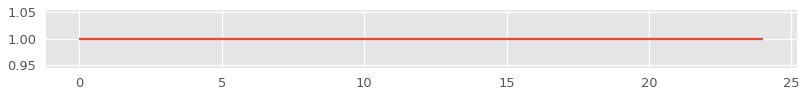

In [650]:
# PROBABILITY SUM CHECK
y = []
for i in range(len(x_path)):
    y = np.append(y,np.round(np.sum(x_path[[i]]),0))
plt.figure(figsize=(12,1)) 
plt.plot(range(len(x_path)),y);

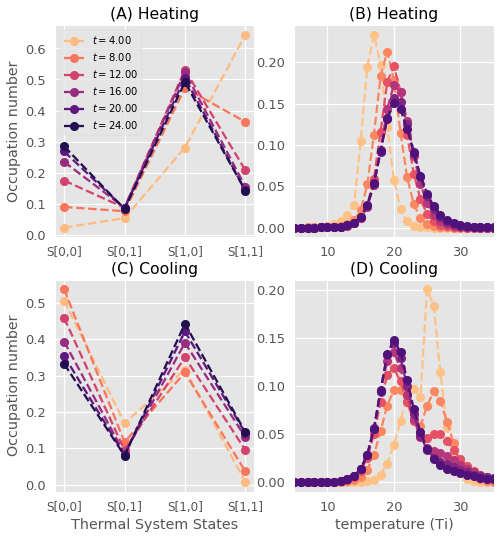

In [651]:
##################################
# PLOT: A: STATE DISTRIBUTION
plt.figure(figsize=(7,8))
plt.subplot(2,2,1)
x1 = [0,1,2,3]
c_list = sns.color_palette("magma_r", 6)
plt.title("(A) Heating")
for idx,t in enumerate(np.arange(0,25,4)):
    if t>0:
        plt.plot(x1,np.sum(x_path[t],axis=0)[0].tolist()+np.sum(x_path[t],axis=0)[1].tolist(),
                 marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$",
                 color=c_list[idx-1])
plt.legend(fontsize=10)
plt.ylabel('Occupation number')
# plt.xlabel('States')
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels,fontsize=12)

##################################
# PLOT: B: Ti DISTRIBUTION
plt.subplot(2,2,2)
plt.title("(B) Heating")
c_list = sns.color_palette("magma_r", 7)

for idx,t in enumerate(np.arange(0,25,4)):
    if t > 0:
        plt.plot(range(temp_states),np.sum(np.sum(x_path[t], axis = 2),axis=1), 
                 marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$",
                color=c_list[idx-1])
# plt.legend()
# plt.ylabel('Occupation number')
# plt.xlabel('temperature (Ti)')
plt.xlim(5,35)

##################################
# PLOT: C: STATE DISTRIBUTION
plt.subplot(2,2,3)
x1 = [0,1,2,3]
c_list = sns.color_palette("magma_r", 6)
plt.title("(C) Cooling")
for idx,t in enumerate(np.arange(0,25,4)):
    if t>0:
        plt.plot(x1,np.sum(x_path_c[t],axis=0)[0].tolist()+np.sum(x_path_c[t],axis=0)[1].tolist(),
                 marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$",
                 color=c_list[idx-1])
# plt.legend(fontsize=10)
plt.ylabel('Occupation number')
plt.xlabel('Thermal System States')
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels,fontsize=12)

# PLOT: D: Ti DISTRIBUTION
plt.subplot(2,2,4)
plt.title("(D) Cooling")
c_list = sns.color_palette("magma_r", 7)

for idx,t in enumerate(np.arange(0,25,4)):
    if t > 0:
        plt.plot(range(temp_states),np.sum(np.sum(x_path_c[t], axis = 2),axis=1), 
                 marker="o", ls='--', label=fr"$t = {t_length*t/t_steps:.2f}$",
                color=c_list[idx-1])
# plt.legend()
# plt.ylabel('Occupation number')
plt.xlabel('temperature (Ti)')
plt.xlim(5,35);

### Building Efficiency

In [665]:
fURL = 'https://raw.githubusercontent.com/fhall18/cchpMasterEquation/main/stateTransitionMatrix.csv'
sMatrix = pd.read_csv(fURL)
sMatrix = sMatrix.melt(id_vars=['var','Ta','Ta_name'], value_vars=['p', 'm'])
sMatrix['var'] = sMatrix['var'].astype(str)+sMatrix['variable'].astype(str)
sMatrix = sMatrix[['var','Ta','Ta_name','value']]

In [667]:
# Time of observations
t_length = 25 # 24-hours (first step is initial stage)
t_steps = 25
t_vec = np.linspace(0, t_length, t_steps)

# Initial conditions
nb_of_states = 2
temp_states = 50 # only really need 10-30... in Celsius

x_0 = np.zeros((temp_states,nb_of_states,nb_of_states,))
startTemp = 15 # Starting Temperature
x_0[startTemp]   = .25
# x_0[startTemp+2] = 3/96
# x_0[startTemp+1] = 5/96
# x_0[startTemp]   = 8/96
# x_0[startTemp-1] = 5/96
# x_0[startTemp-2] = 3/96

# Temp Transitions
L = .8
F = .5
H = .3
omega = .8

Tset = 20 # Setpoint Temperature
Ph = []
Pc = []
for i in range(temp_states):
    x = tProb(i,Tset,-2,.8)
    Pc.append(x)
    Ph.append(1-x)


TaList = [-15,-10,-5,0,5,10]
TaSetTransitions = [1,1,2,3,3,4]

saved_path_3 = []
saved_path_6 = []
saved_path_12 = []
saved_path_24 = []

# for Ta in range(-15,15,1):
for Ta,i in zip(TaList,TaSetTransitions):
    sub = sMatrix.loc[(sMatrix['Ta'] == i)].reset_index(drop=True)
    var = sub['var'].reset_index(drop=True)
    val = sub['value']
    
    # Evaluates transition matrix at given T_a
    phi_p = val[0]
    alpha_p = val[1]
    gamma_p = val[2]
    beta_p = val[3]
    phi_m = val[4]
    alpha_m = val[5]
    gamma_m = val[6]
    beta_m = val[7]
    
    h_eff = hEfficiency(Ta)
    f_eff = fEfficiency(Ta)
    G = lambda x, t: J3(x, alpha_p,alpha_m,phi_p,phi_m,gamma_p,gamma_m,beta_p,beta_m,L,F,H,omega,Ph,Pc,h_eff,f_eff)
    x_path = odeintw(G, x_0, t_vec)
    
    saved_path_3.append(x_path[3])
    saved_path_6.append(x_path[6])
    saved_path_12.append(x_path[12])
    saved_path_24.append(x_path[24])

#### $T_a$ ADJUSTED THROUGH TIME

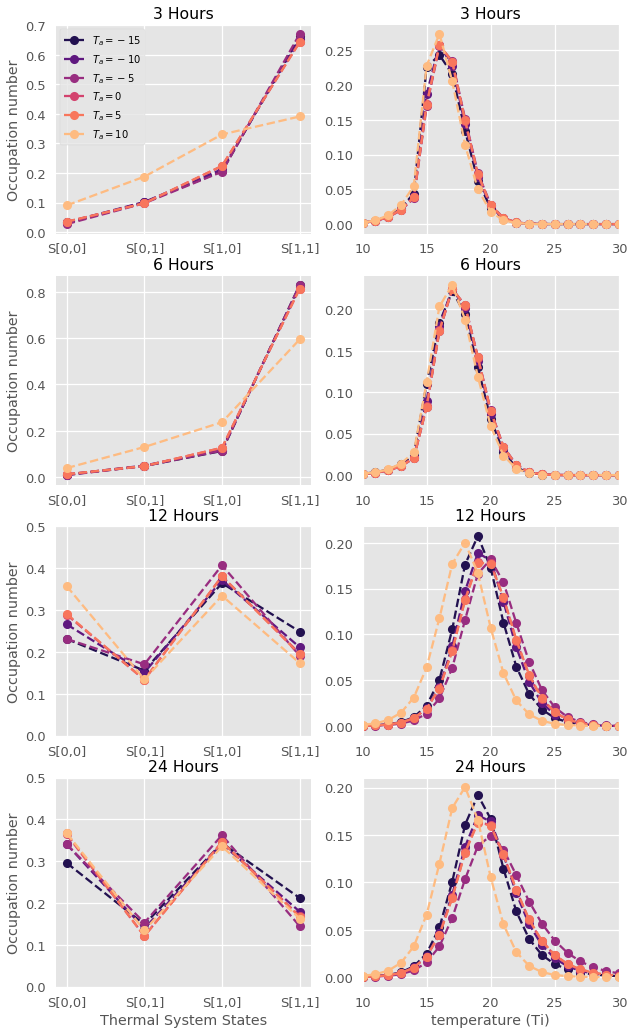

In [668]:


# plt.style.use('ggplot')
plt.figure(figsize=(9,16.5),facecolor='white',edgecolor='white')
c_list = sns.color_palette("magma", 6)

# FIRST SET
plt.subplot(4,2,1)
plt.title("3 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    
    plt.plot(x1,np.sum(saved_path_3[t],axis=0)[0].tolist()+np.sum(saved_path_3[t],axis=0)[1].tolist(),
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
             color=c_list[idx])
plt.ylabel('Occupation number')
plt.legend(fontsize=10)
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['State[0,0]', 'State[0,1]','State[1,0]','State[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels)
# plt.ylim(0,.5)

plt.subplot(4,2,2)
plt.title("3 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    
    plt.plot(range(temp_states),np.sum(np.sum(saved_path_3[t], axis = 2),axis=1), 
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
            color=c_list[idx])
# plt.ylabel('Occupation number')
# plt.xlabel('temperature (Ti)')
plt.xlim(10,30)

# SECOND SET
plt.subplot(4,2,3)
plt.title("6 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    plt.plot(x1,np.sum(saved_path_5[t],axis=0)[0].tolist()+np.sum(saved_path_5[t],axis=0)[1].tolist(),
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
             color=c_list[idx])
plt.ylabel('Occupation number')
# plt.legend(fontsize=10)
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['State[0,0]', 'State[0,1]','State[1,0]','State[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels)
# plt.ylim(0,.5)

plt.subplot(4,2,4)
plt.title("6 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    
    plt.plot(range(temp_states),np.sum(np.sum(saved_path_5[t], axis = 2),axis=1), 
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
            color=c_list[idx])
# plt.ylabel('Occupation number')
# plt.xlabel('temperature (Ti)')
plt.xlim(10,30)

# THIRD SET
plt.subplot(4,2,5)
plt.title("12 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    plt.plot(x1,np.sum(saved_path_12[t],axis=0)[0].tolist()+np.sum(saved_path_12[t],axis=0)[1].tolist(),
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
             color=c_list[idx])
plt.ylabel('Occupation number')
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['State[0,0]', 'State[0,1]','State[1,0]','State[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels)
plt.ylim(0,.5)

plt.subplot(4,2,6)
plt.title("12 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    
    plt.plot(range(temp_states),np.sum(np.sum(saved_path_12[t], axis = 2),axis=1), 
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
            color=c_list[idx])
# plt.ylabel('Occupation number')
# plt.xlabel('temperature (Ti)')
plt.xlim(10,30)

# FOURTH SET
plt.subplot
plt.subplot(4,2,7)
plt.title("24 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    plt.plot(x1,np.sum(saved_path_24[t],axis=0)[0].tolist()+np.sum(saved_path_24[t],axis=0)[1].tolist(),
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
             color=c_list[idx])
plt.ylabel('Occupation number')

# labels = ['State[0,0]', 'State[0,1]','State[1,0]','State[1,1]']
labels = ['S[0,0]', 'S[0,1]','S[1,0]','S[1,1]']
# labels = ['Off', 'Fossil','Heat Pump','All']
plt.xticks(x1, labels)
plt.ylim(0,.5)
plt.xlabel('Thermal System States')

plt.subplot(4,2,8)
plt.title("24 Hours")
for idx, (t,Ta) in enumerate(zip(np.arange(0,6,1),TaList)):
    
    plt.plot(range(temp_states),np.sum(np.sum(saved_path_24[t], axis = 2),axis=1), 
             marker="o", ls='--', label=fr"$T_a = {Ta}$",
            color=c_list[idx])
# plt.ylabel('Occupation number')
plt.xlabel('temperature (Ti)')
plt.xlim(10,30)
plt.savefig('TaDist.png',dpi=300)

# NEXT STEPS - FLM
- Consider different Ti reductions at different Ta states
- What is the temperature drop?
- When does the fossil fuel system turn on?
- How does the HP rebound afterwords?